<a href="https://colab.research.google.com/github/Aziz-ur-Rehman11/Fine-Tuning-MobileNet-on-Food-101-Dataset/blob/main/Fine_Tuning_MobileNet_on_Food_101_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning using Transfer Learning on MobileNet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the Dataset

In [ ]:
!kaggle datasets download dansbecker/food-101

Dataset URL: https://www.kaggle.com/datasets/dansbecker/food-101
License(s): other
100% 9.38G/9.38G [04:21<00:00, 44.3MB/s]
100% 9.38G/9.38G [04:21<00:00, 38.4MB/s]


In [ ]:
!unzip -o /content/food-101.zip > /dev/null
!rm -r /content/food-101/__MACOSX
!rm -r /content/food-101.zip

# Importing Libraries

In [ ]:
import json
import tensorflow
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
main_path = '/content/food-101/food-101'

In [ ]:
class_names = pd.read_csv(main_path +'/meta/classes.txt', sep=' ', header=None)
class_names

0
0         apple_pie
1    baby_back_ribs
2           baklava
3    beef_carpaccio
4      beef_tartare
..              ...
96            tacos
97         takoyaki
98         tiramisu
99     tuna_tartare
100         waffles

[101 rows x 1 columns]

In [ ]:
with open(main_path + '/meta/train.txt', 'r') as f:
  train_images = f.read().splitlines()

with open(main_path + '/meta/test.txt', 'r') as f:
  test_images = f.read().splitlines()

In [ ]:
train_images = [(main_path + '/images/' + str(x) + '.jpg') for x in train_images]
test_images = [(main_path + '/images/' + str(x) + '.jpg') for x in test_images]

In [ ]:
train_labels = [x.split('/')[5] for x in train_images]
test_labels = [x.split('/')[5] for x in test_images]

In [ ]:
unique_train_labels = set(train_labels)
print(f"Number of Unique Labels: {len(unique_train_labels)}")
# for label in unique_train_labels:
#   print(f"Label: {label}, Train Images: {train_labels.count(label)}, Test Images: {test_labels.count(label)}")

Number of Unique Labels: 101


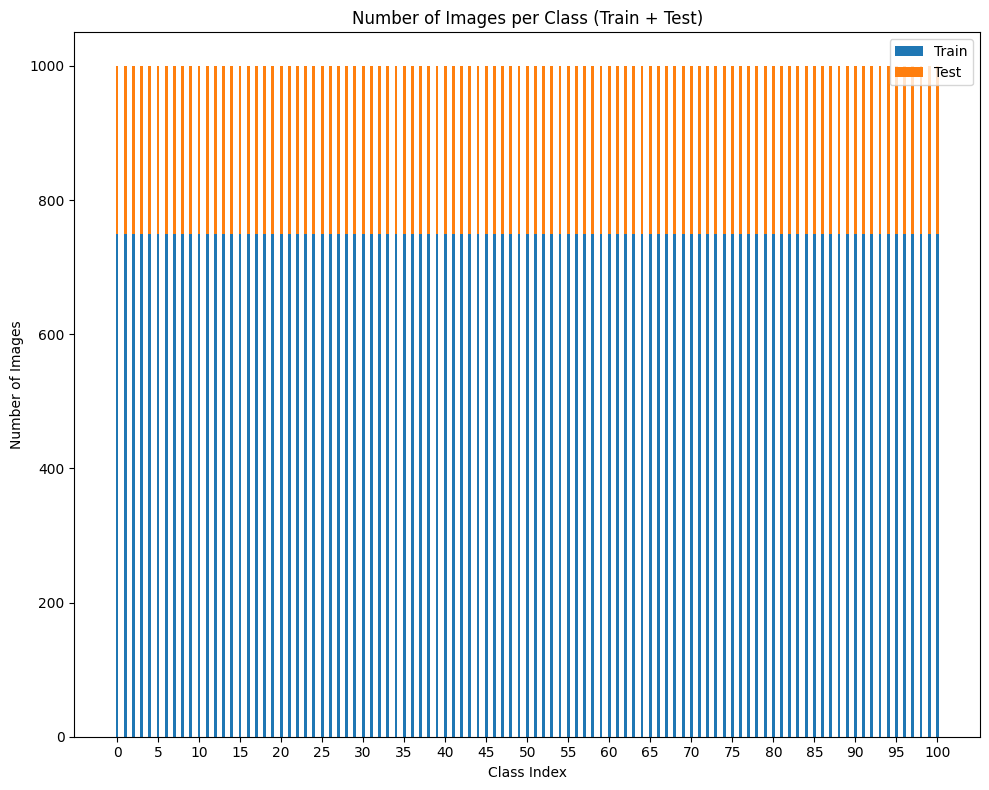

In [ ]:
label_counts = {}
for label in unique_train_labels:
    label_counts[label] = {
        'train': train_labels.count(label),
        'test': test_labels.count(label)
    }
labels = list(label_counts.keys())
train_counts = [label_counts[label]['train'] for label in labels]
test_counts = [label_counts[label]['test'] for label in labels]
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
width = 0.35  # Width of the bars
plt.bar(range(len(labels)), train_counts, width, label='Train')
plt.bar(range(len(labels)), test_counts, width, bottom=train_counts, label='Test')
plt.xlabel('Class Index') # Change x-axis label
plt.ylabel('Number of Images')
plt.title('Number of Images per Class (Train + Test)')
plt.xticks(range(0, len(labels), 5)) # Set x-axis ticks every 5 labels
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

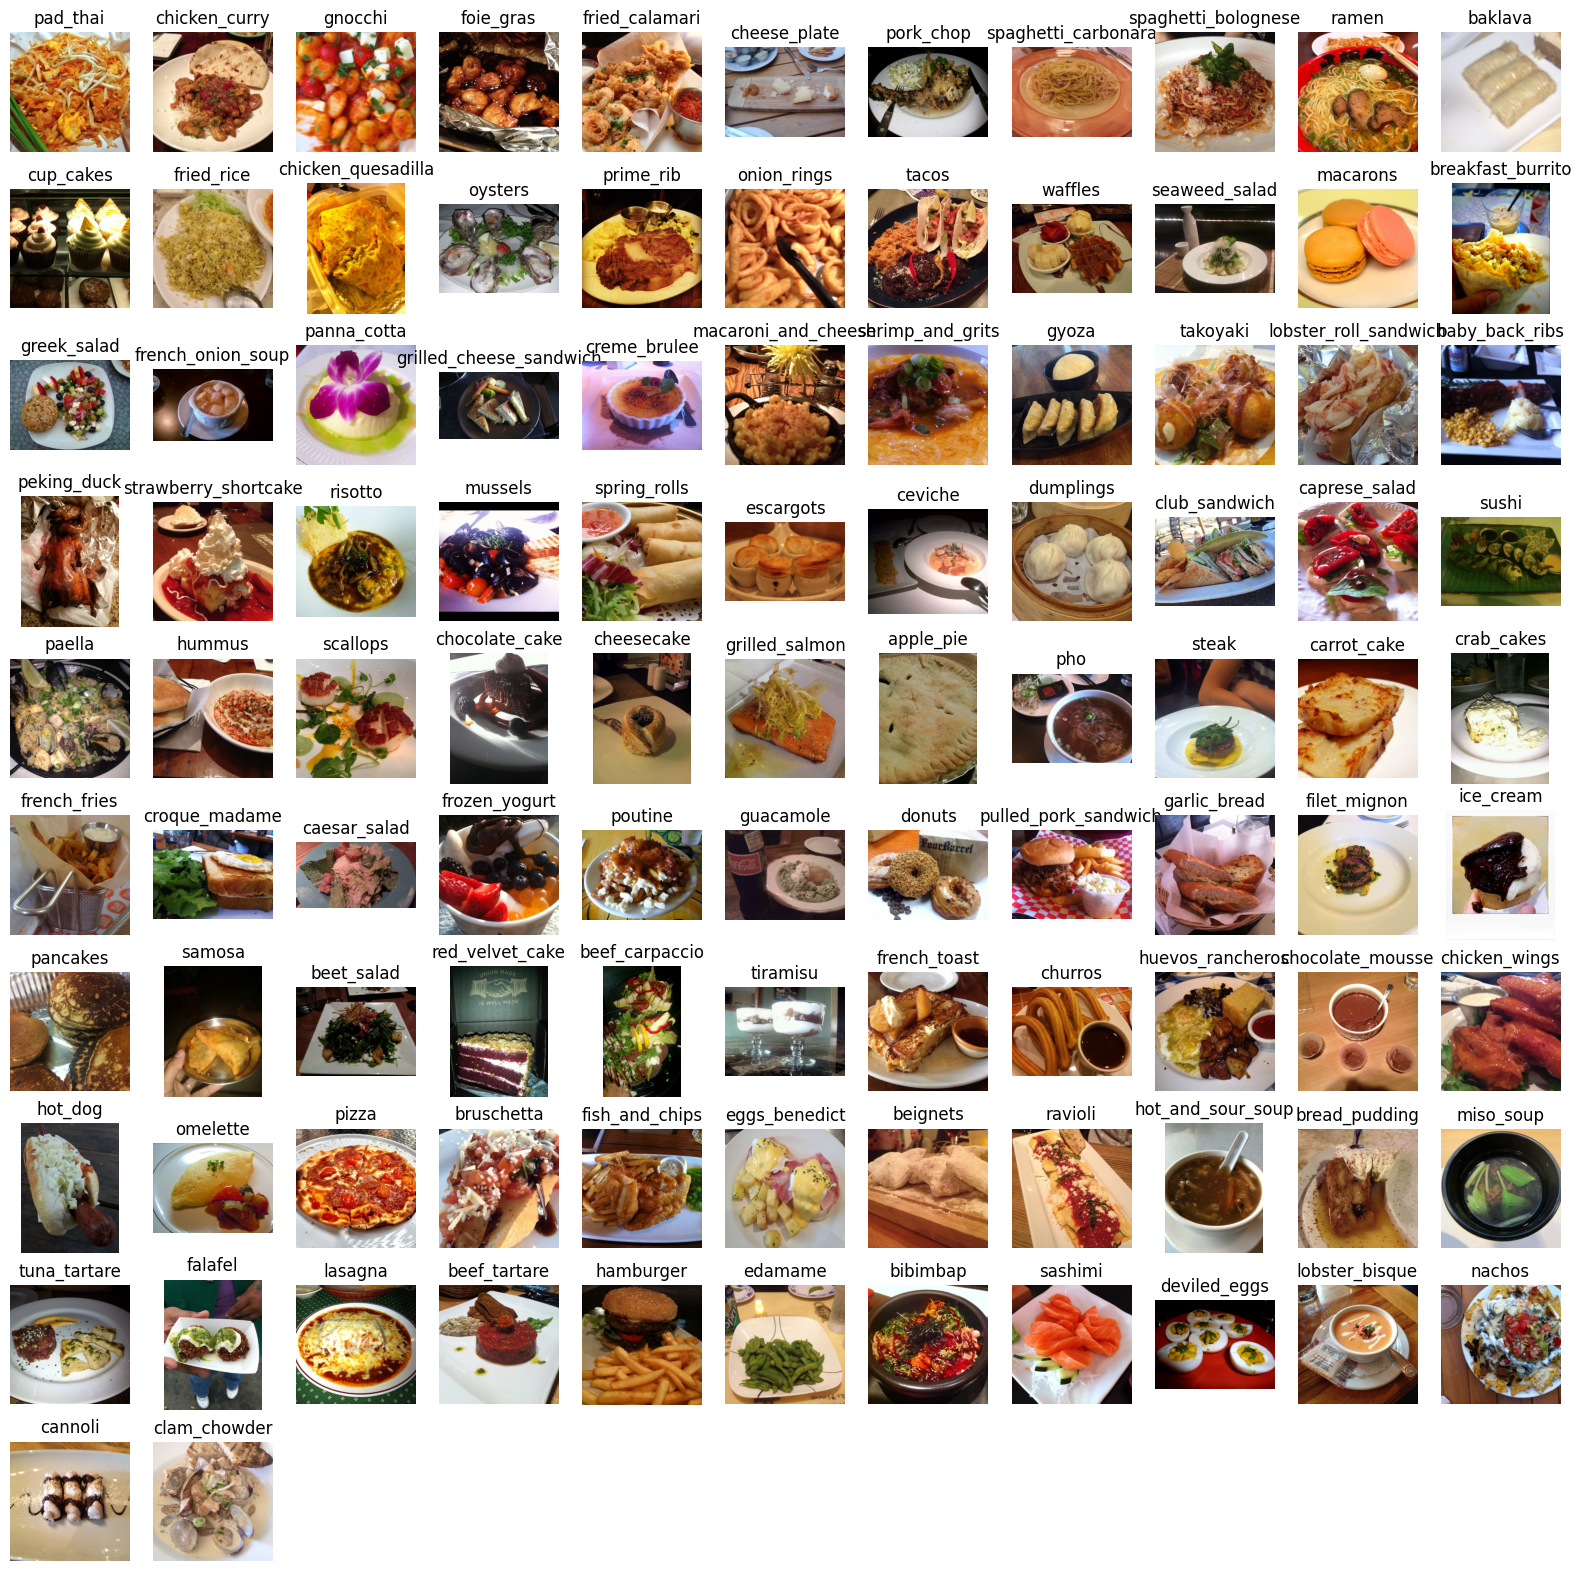

In [ ]:
plt.figure(figsize=(20, 20))
counter = 0

for class_name in os.listdir(os.path.join(main_path, 'images')):
  class_dir = os.path.join(main_path, 'images', class_name)

  if os.path.isdir(class_dir):

    for image_file in os.listdir(class_dir)[:1]:

      image_path = os.path.join(class_dir, image_file)
      img = plt.imread(image_path)

      plt.subplot(10, 11, counter + 1)
      plt.imshow(img)
      plt.title(class_name)
      plt.axis('off')
      counter += 1

In [ ]:
train_df = pd.DataFrame({'image': train_images, 'label': train_labels})
test_df = pd.DataFrame({'image': test_images, 'label': test_labels})

train_df, val_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.2, random_state=42)

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((60600, 2), (15150, 2), (25250, 2))

You may also Augment the images if you want to

In [ ]:
main__generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,

    # # Data Augmentation
    # rotation_range=20, # Rotate images by up to 20 degrees
    # width_shift_range=0.2, # Shift images horizontally by up to 20% of the width
    # height_shift_range=0.2, # Shift images vertically by up to 20% of the height
    # shear_range=0.2, # Apply shear transformations
    # zoom_range=0.2, # Zoom in or out on images
    # horizontal_flip=True, # Flip images horizontally
    # fill_mode='nearest', # Fill in missing pixels with the nearest value
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = main__generator.flow_from_dataframe(
    dataframe=train_df,

    x_col='image',
    y_col='label',

    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,

    shuffle=True,
    seed=42,
)

val_images = main__generator.flow_from_dataframe(
    dataframe=val_df,

    x_col='image',
    y_col='label',

    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,

    shuffle=True,
    seed=42,

)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,

    x_col='image',
    y_col='label',

    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,

    shuffle=False
)

Found 60600 validated image filenames belonging to 101 classes.
Found 15150 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


# We got run the above code, every time a new iterations is to be performed. It just imports the datasets and saves the image/labels. As the size of the data is too large, my drive did nt have anough space to contain them, hance the temp/remote data extraction

# First Model Iteration

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),

    include_top=False,
    input_tensor=None,

    weights='imagenet',
    pooling='avg'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


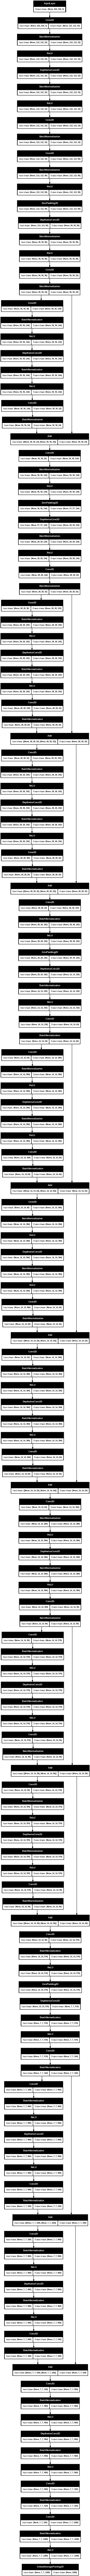

In [ ]:
tf.keras.utils.plot_model(pretrained_model, show_shapes=True, dpi=48)

In [ ]:
pretrained_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = pretrained_model(inputs, training = False)

if len(x.shape) == 4:
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) # Add dropout with a rate of 0.2

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) # Add dropout with a rate of 0.2

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 101)                 │          13,029 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,451,493 (9.35 MB)

 Trainable params: 193,509 (755.89 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

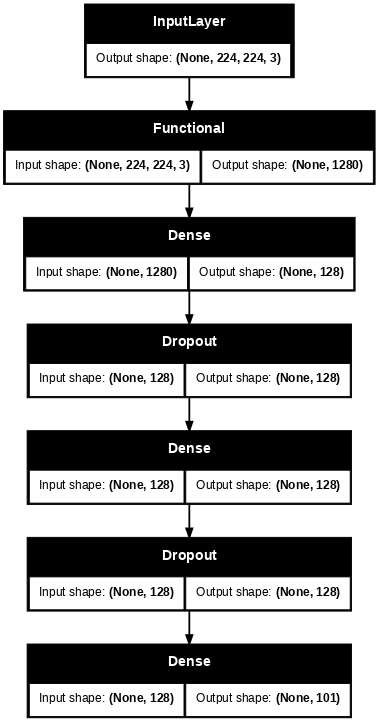

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
model.compile(
    optimizer= tf.keras.optimizers.AdamW(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Initial Performance of the model

790/790 ━━━━━━━━━━━━━━━━━━━━ 107s 135ms/step - accuracy: 0.0128 - loss: 4.7766 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 4.7481
Accuracy: 0.0110
Precision: 0.0000
Recall: 0.0000
790/790 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step


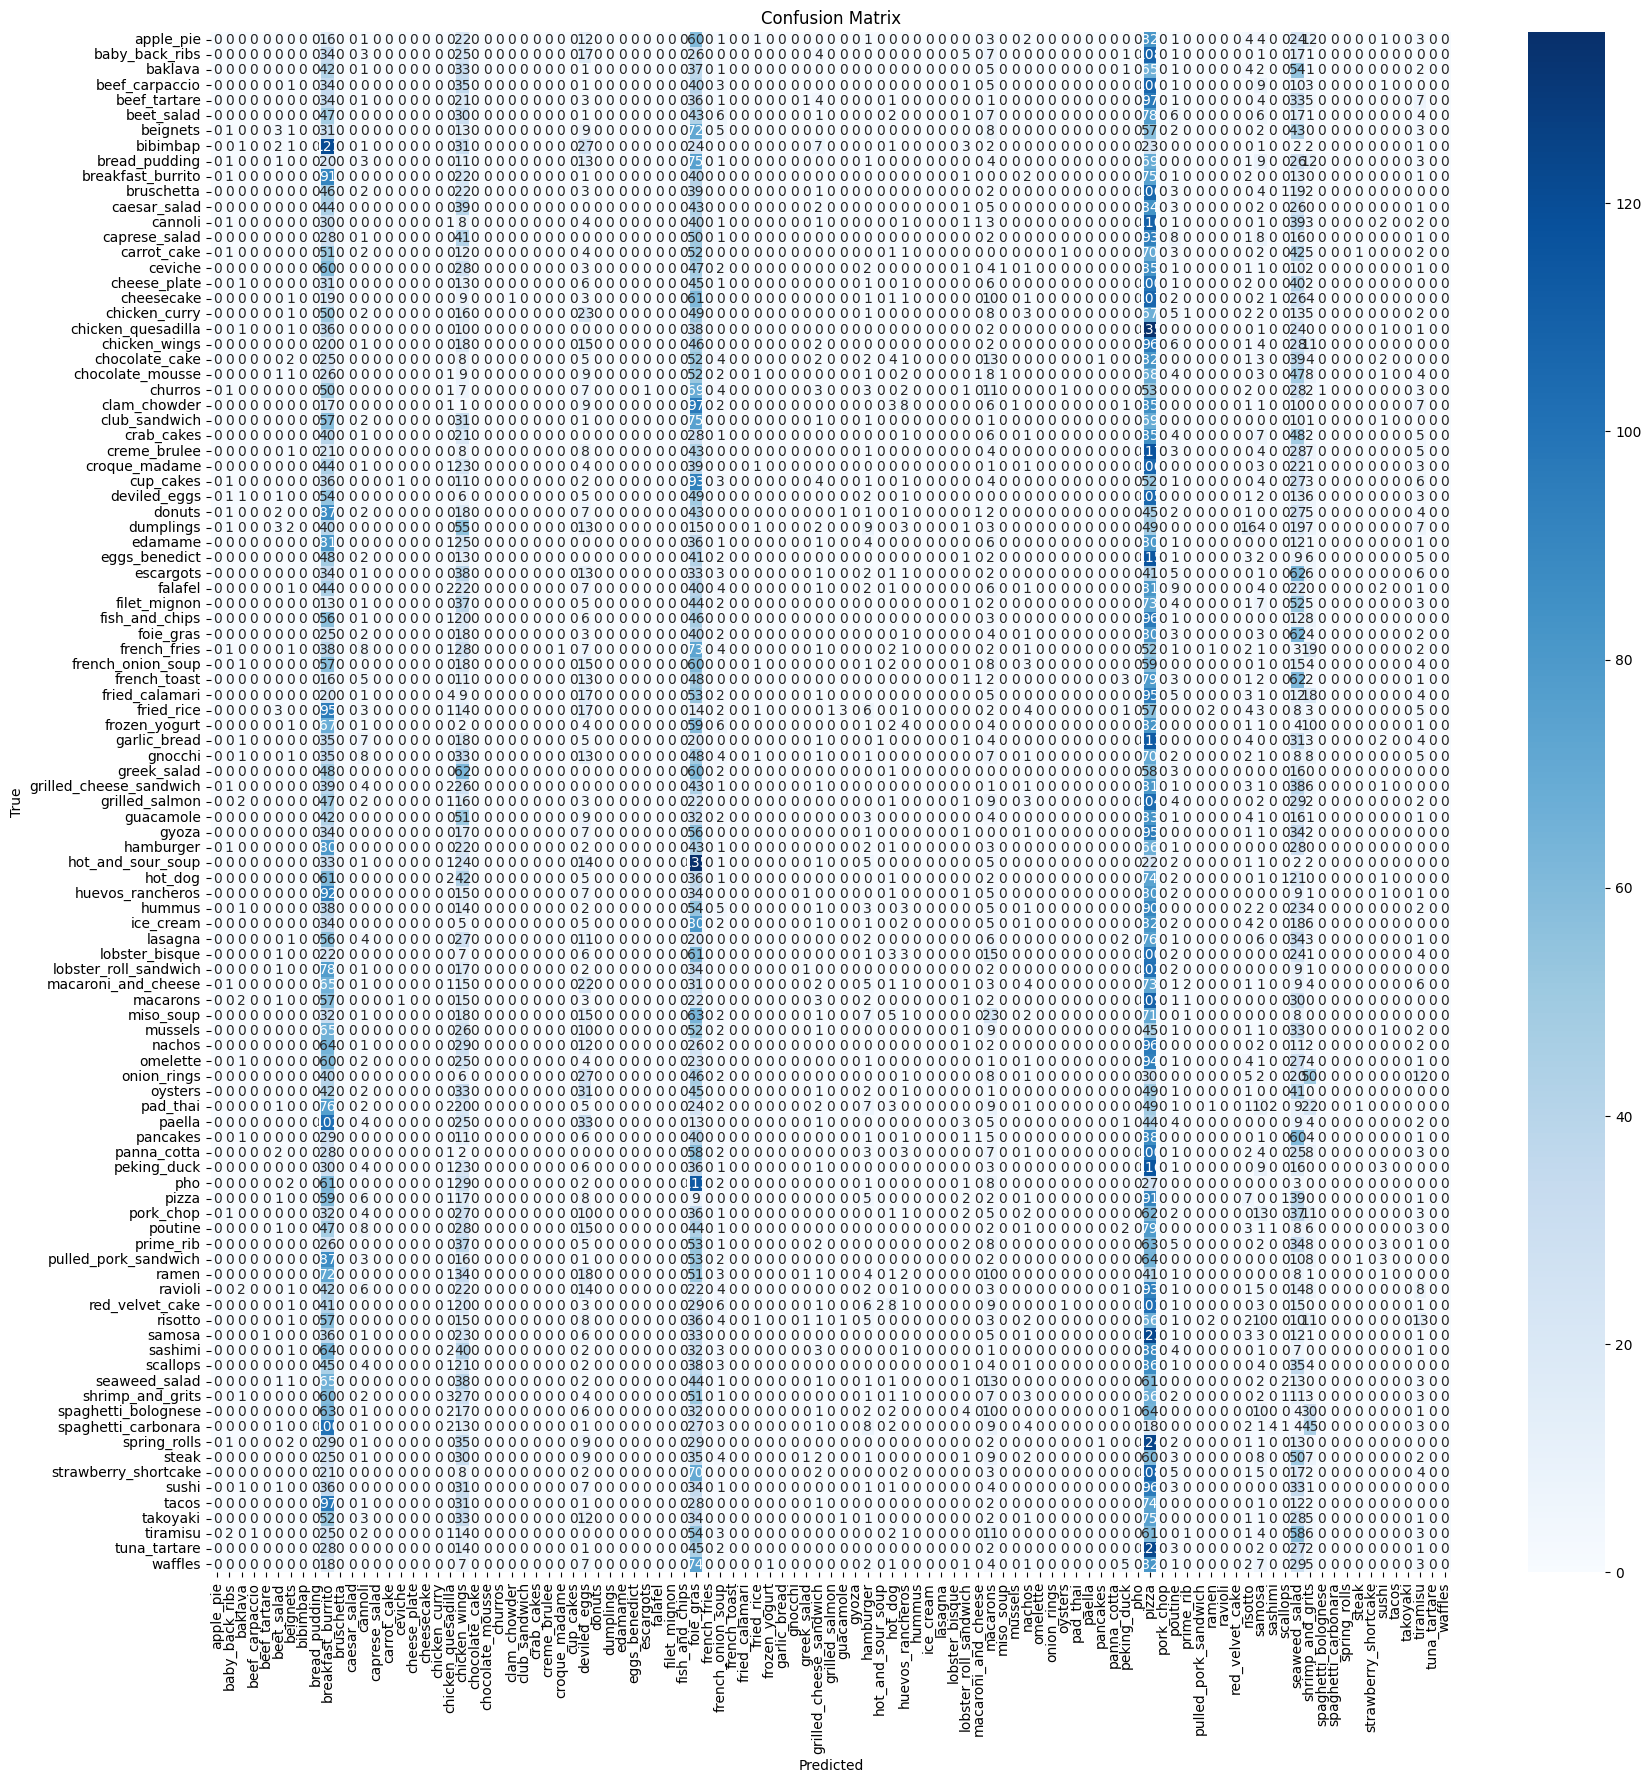

In [ ]:
loss_value, accuracy_value, precision_value, recall_value = model.evaluate(test_images)

# Update subsequent print statements accordingly:
print(f"Loss: {loss_value:.4f}")
print(f"Accuracy: {accuracy_value:.4f}")
print(f"Precision: {precision_value:.4f}")
print(f"Recall: {recall_value:.4f}")

# get the predicted labeks
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = test_images.classes

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_images.class_indices.keys()),
            yticklabels=list(test_images.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Initial Traing with Mobilenetv2 layers fully Freezed

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 346s 174ms/step - accuracy: 0.0659 - loss: 4.3228 - val_accuracy: 0.3458 - val_loss: 2.8140
Epoch 2/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 266s 140ms/step - accuracy: 0.2814 - loss: 2.9675 - val_accuracy: 0.4288 - val_loss: 2.3624
Epoch 3/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 251s 132ms/step - accuracy: 0.3599 - loss: 2.5747 - val_accuracy: 0.4677 - val_loss: 2.1708
Epoch 4/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 282s 143ms/step - accuracy: 0.4016 - loss: 2.3933 - val_accuracy: 0.4854 - val_loss: 2.0623
Epoch 5/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 343s 154ms/step - accuracy: 0.4257 - loss: 2.2609 - val_accuracy: 0.5011 - val_loss: 1.9894
Epoch 6/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 256s 135ms/step - accuracy: 0.4518 - loss: 2.1648 - val_accuracy: 0.5094 - val_loss: 1.9430
Epoch 7/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 278s 143ms/step - accuracy: 0.4658 - loss: 2.0776 - val_accuracy: 0.5171 - val_loss: 1.9018
Epoch 8/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 275s 118ms/step - accuracy: 0.4

In [ ]:
model.save('/content/drive/MyDrive/Mymodels/Checkpoint1.h5')
history_dict = history.history


json_history = json.dumps(history_dict)

# Save the JSON string to a file
with open('training_history.json', 'w') as f:
    f.write(json_history)

with open('/content/drive/MyDrive/Mymodels/Checkpoint1.json', 'w') as f:
    f.write(json_history)

# let us retrain for 10 more epochs

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Mymodels/Checkpoint1.h5')

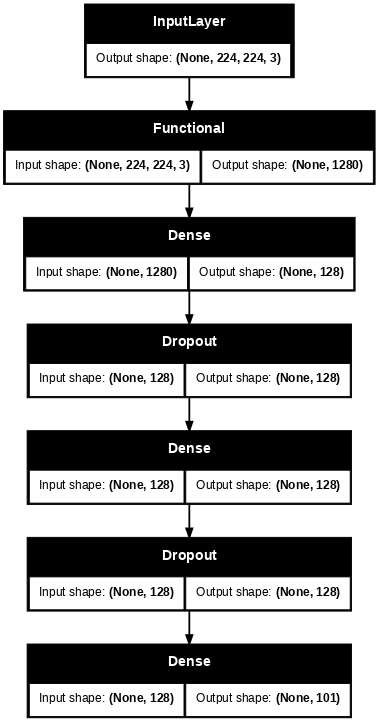

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
model.compile(
    optimizer= tf.keras.optimizers.AdamW(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_2 = model.fit(train_images,
                      validation_data=val_images,

                      epochs=20,
                      initial_epoch=10,

                      callbacks=[
                          tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=3
                              )
                          ]
)

Epoch 11/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 321s 162ms/step - accuracy: 0.5098 - loss: 1.8870 - val_accuracy: 0.5376 - val_loss: 1.8171
Epoch 12/20
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 268s 141ms/step - accuracy: 0.5267 - loss: 1.8418 - val_accuracy: 0.5380 - val_loss: 1.8094
Epoch 13/20
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 249s 131ms/step - accuracy: 0.5272 - loss: 1.8171 - val_accuracy: 0.5428 - val_loss: 1.7907
Epoch 14/20
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 303s 153ms/step - accuracy: 0.5382 - loss: 1.7796 - val_accuracy: 0.5435 - val_loss: 1.7812
Epoch 15/20
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 324s 154ms/step - accuracy: 0.5454 - loss: 1.7439 - val_accuracy: 0.5450 - val_loss: 1.7744
Epoch 16/20
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 250s 132ms/step - accuracy: 0.5509 - loss: 1.7193 - val_accuracy: 0.5463 - val_loss: 1.7699
Epoch 17/20
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 250s 132ms/step - accuracy: 0.5492 - loss: 1.7069 - val_accuracy: 0.5467 - val_loss: 1.7615
Epoch 18/20
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 255s 134ms/step - accura

In [ ]:
loss1, accuracy1 = model.evaluate(test_images, verbose=0)

print("Loss: {:.2f}".format(loss1))
print("Accuracy: {:.2f}".format(accuracy1))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


initial loss: 1.49
initial accuracy: 0.60


In [ ]:
model.save('/content/drive/MyDrive/Mymodels/Checkpoint2.h5')

history_dict = history_2.history


json_history = json.dumps(history_dict)

# Save the JSON string to a file
with open('training_history.json', 'w') as f:
    f.write(json_history)

with open('/content/drive/MyDrive/Mymodels/Checkpoint2.json', 'w') as f:
    f.write(json_history)

# Plotting Current Model Results

In [ ]:
with open('/content/drive/MyDrive/Mymodels/Checkpoint1.json', 'r') as f:
    history1 = json.load(f)

with open('/content/drive/MyDrive/Mymodels/Checkpoint2.json', 'r') as f:
    history2 = json.load(f)

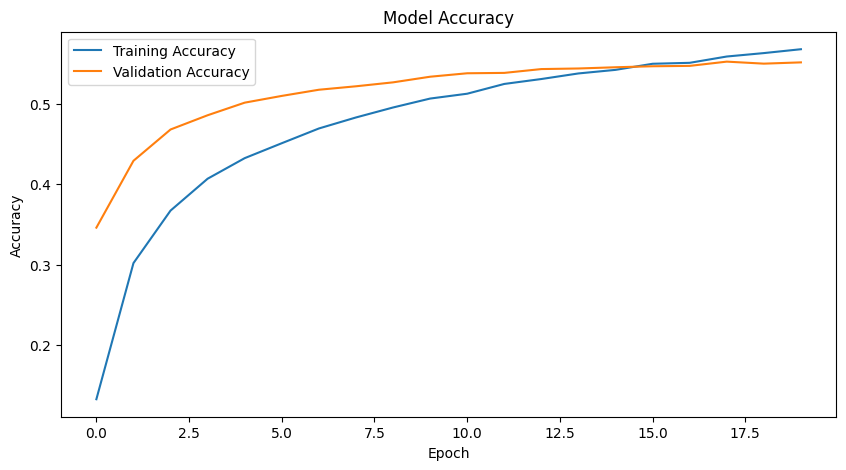

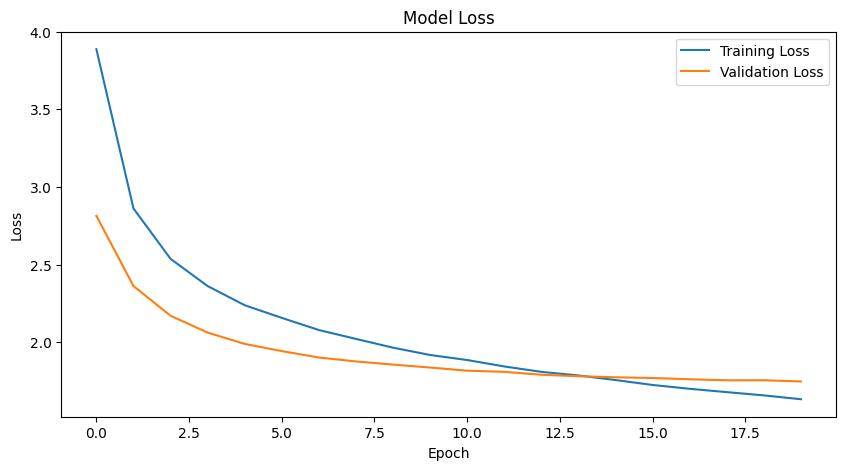

In [ ]:
acc = history1['accuracy'] + history2['accuracy']
val_acc = history1['val_accuracy'] + history2['val_accuracy']
loss = history1['loss'] + history2['loss']
val_loss = history1['val_loss'] + history2['val_loss']


plt.figure(figsize=(10, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# Finetuning With Initial Unfreezed Layers

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Mymodels/Checkpoint2.h5')

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 101)                 │          13,029 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,451,495 (9.35 MB)

 Trainable params: 193,509 (755.89 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
mobilenet_layers = model.layers[1]

mobilenet_layers.trainable = True

print("Total Number of Layers in Mobile Net: ", len(mobilenet_layers.layers))

Total Number of Layers in Mobile Net:  155


In [ ]:
for layer in mobilenet_layers.layers[:100]: # only freeze the layers before 100 layer
  layer.trainable = False

mobilenet_layers.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
model.layers[1] = mobilenet_layers
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 101)                 │          13,029 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,451,495 (9.35 MB)

 Trainable params: 2,054,949 (7.84 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Recompile the model (important after changing trainable status)
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00001), # lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
history3 = model.fit(
    train_images,
    validation_data=val_images,

    epochs=30,
    initial_epoch=20,

    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 21/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 393s 192ms/step - accuracy: 0.3691 - loss: 2.5888 - precision: 0.7367 - recall: 0.1915 - val_accuracy: 0.5388 - val_loss: 1.8131 - val_precision: 0.7902 - val_recall: 0.3962
Epoch 22/30
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 311s 164ms/step - accuracy: 0.5121 - loss: 1.8923 - precision: 0.7891 - recall: 0.3414 - val_accuracy: 0.5589 - val_loss: 1.7132 - val_precision: 0.8072 - val_recall: 0.4158
Epoch 23/30
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 302s 159ms/step - accuracy: 0.5533 - loss: 1.7179 - precision: 0.8060 - recall: 0.3877 - val_accuracy: 0.5797 - val_loss: 1.6360 - val_precision: 0.8098 - val_recall: 0.4446
Epoch 24/30
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 331s 174ms/step - accuracy: 0.5749 - loss: 1.6161 - precision: 0.8148 - recall: 0.4144 - val_accuracy: 0.5931 - val_loss: 1.5838 - val_precision: 0.8098 - val_recall: 0.4650
Epoch 25/30
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 297s 156ms/step - accuracy: 0.5966 - loss: 1.5209 - precision: 0.8232 - recall: 0.4440 - val_accuracy

In [ ]:
model.save('/content/drive/MyDrive/Mymodels/Checkpoint3.h5')
history_dict = history3.history


json_history = json.dumps(history_dict)

# Save the JSON string to a file
with open('training_history.json', 'w') as f:
    f.write(json_history)

with open('/content/drive/MyDrive/Mymodels/Checkpoint3.json', 'w') as f:
    f.write(json_history)

# Final Model Retraining with a lower Learning Rate

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Mymodels/Checkpoint3.h5')

# Compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.000001),  # Further reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
# Continue training for 20 more epochs
history4 = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    initial_epoch=30,   # Continue from the previous epoch count
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 31/50
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 386s 191ms/step - accuracy: 0.6866 - loss: 1.1347 - precision_1: 0.8626 - recall_1: 0.5562 - val_accuracy: 0.6277 - val_loss: 1.4446 - val_precision_1: 0.8075 - val_recall_1: 0.5265
Epoch 32/50
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 331s 170ms/step - accuracy: 0.6848 - loss: 1.1445 - precision_1: 0.8618 - recall_1: 0.5505 - val_accuracy: 0.6290 - val_loss: 1.4425 - val_precision_1: 0.8081 - val_recall_1: 0.5282
Epoch 33/50
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 388s 173ms/step - accuracy: 0.6891 - loss: 1.1320 - precision_1: 0.8626 - recall_1: 0.5570 - val_accuracy: 0.6292 - val_loss: 1.4417 - val_precision_1: 0.8076 - val_recall_1: 0.5296
Epoch 34/50
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 326s 172ms/step - accuracy: 0.6874 - loss: 1.1300 - precision_1: 0.8607 - recall_1: 0.5590 - val_accuracy: 0.6296 - val_loss: 1.4409 - val_precision_1: 0.8070 - val_recall_1: 0.5305
Epoch 35/50
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 438s 201ms/step - accuracy: 0.6938 - loss: 1.1090 - preci

In [ ]:
model.save('/content/drive/MyDrive/Mymodels/Checkpoint4.h5')
history_dict = history4.history


json_history = json.dumps(history_dict)

# Save the JSON string to a file
with open('training_history.json', 'w') as f:
    f.write(json_history)

with open('/content/drive/MyDrive/Mymodels/Checkpoint4.json', 'w') as f:
    f.write(json_history)

# Training Loss and Accuracy Visualization as per epochs

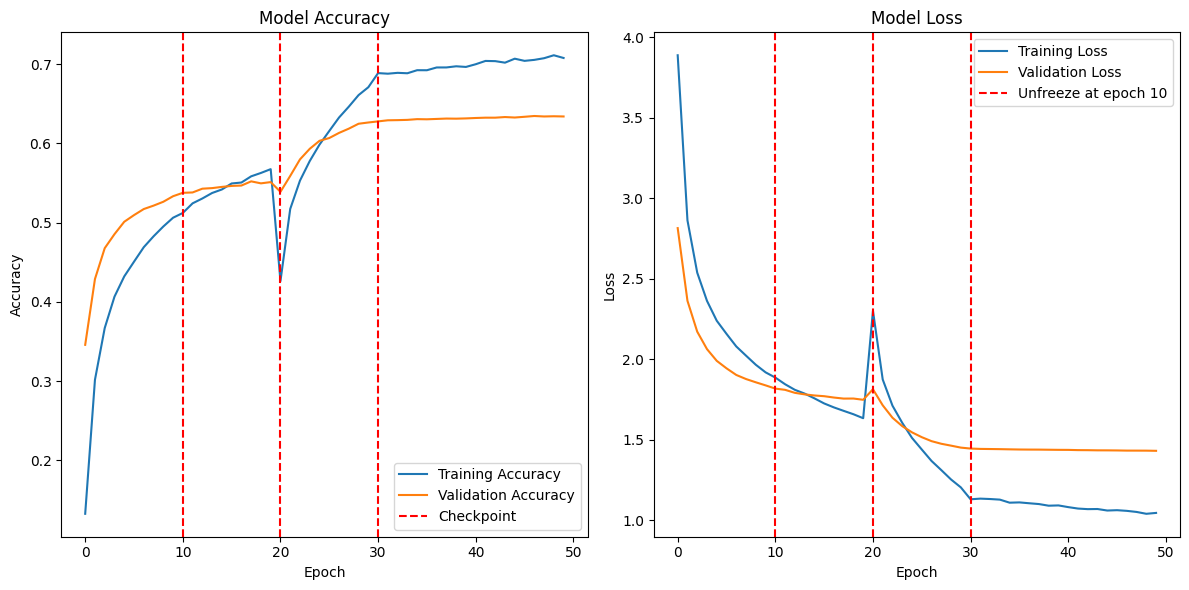

In [ ]:
with open('/content/drive/MyDrive/Mymodels/Checkpoint1.json', 'r') as f:
    history1 = json.load(f)
with open('/content/drive/MyDrive/Mymodels/Checkpoint2.json', 'r') as f:
    history2 = json.load(f)
with open('/content/drive/MyDrive/Mymodels/Checkpoint3.json', 'r') as f:
    history3 = json.load(f)
with open('/content/drive/MyDrive/Mymodels/Checkpoint4.json', 'r') as f:
    history4 = json.load(f)

# Combine history data
acc = history1['accuracy'] + history2['accuracy'] + history3['accuracy'] + history4['accuracy']
val_acc = history1['val_accuracy'] + history2['val_accuracy'] + history3['val_accuracy'] + history4['val_accuracy']
loss = history1['loss'] + history2['loss'] + history3['loss'] + history4['loss']
val_loss = history1['val_loss'] + history2['val_loss'] + history3['val_loss'] + history4['val_loss']

# Epochs where learning rate was changed
unfreeze_epochs = [10, 20, 30]  # Replace with your actual unfreeze epochs

# Plotting
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
for epoch in unfreeze_epochs:
    plt.axvline(x=epoch, color='red', linestyle='--', label=f'Checkpoint' if epoch == unfreeze_epochs[0] else '')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()


# Loss plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
for epoch in unfreeze_epochs:
    plt.axvline(x=epoch, color='red', linestyle='--', label=f'Checkpoint' if epoch == unfreeze_epochs[0] else '')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Final Model Evaluation

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Mymodels/Checkpoint4.h5')

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.000001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

loss, accuracy, precision, recall = model.evaluate(test_images)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


790/790 ━━━━━━━━━━━━━━━━━━━━ 157s 187ms/step - accuracy: 0.6714 - loss: 1.2165 - precision_2: 0.8246 - recall_2: 0.5759
Test Loss: 1.1424
Test Accuracy: 0.6909
Test Precision: 0.8323
Test Recall: 0.5971


790/790 ━━━━━━━━━━━━━━━━━━━━ 105s 128ms/step


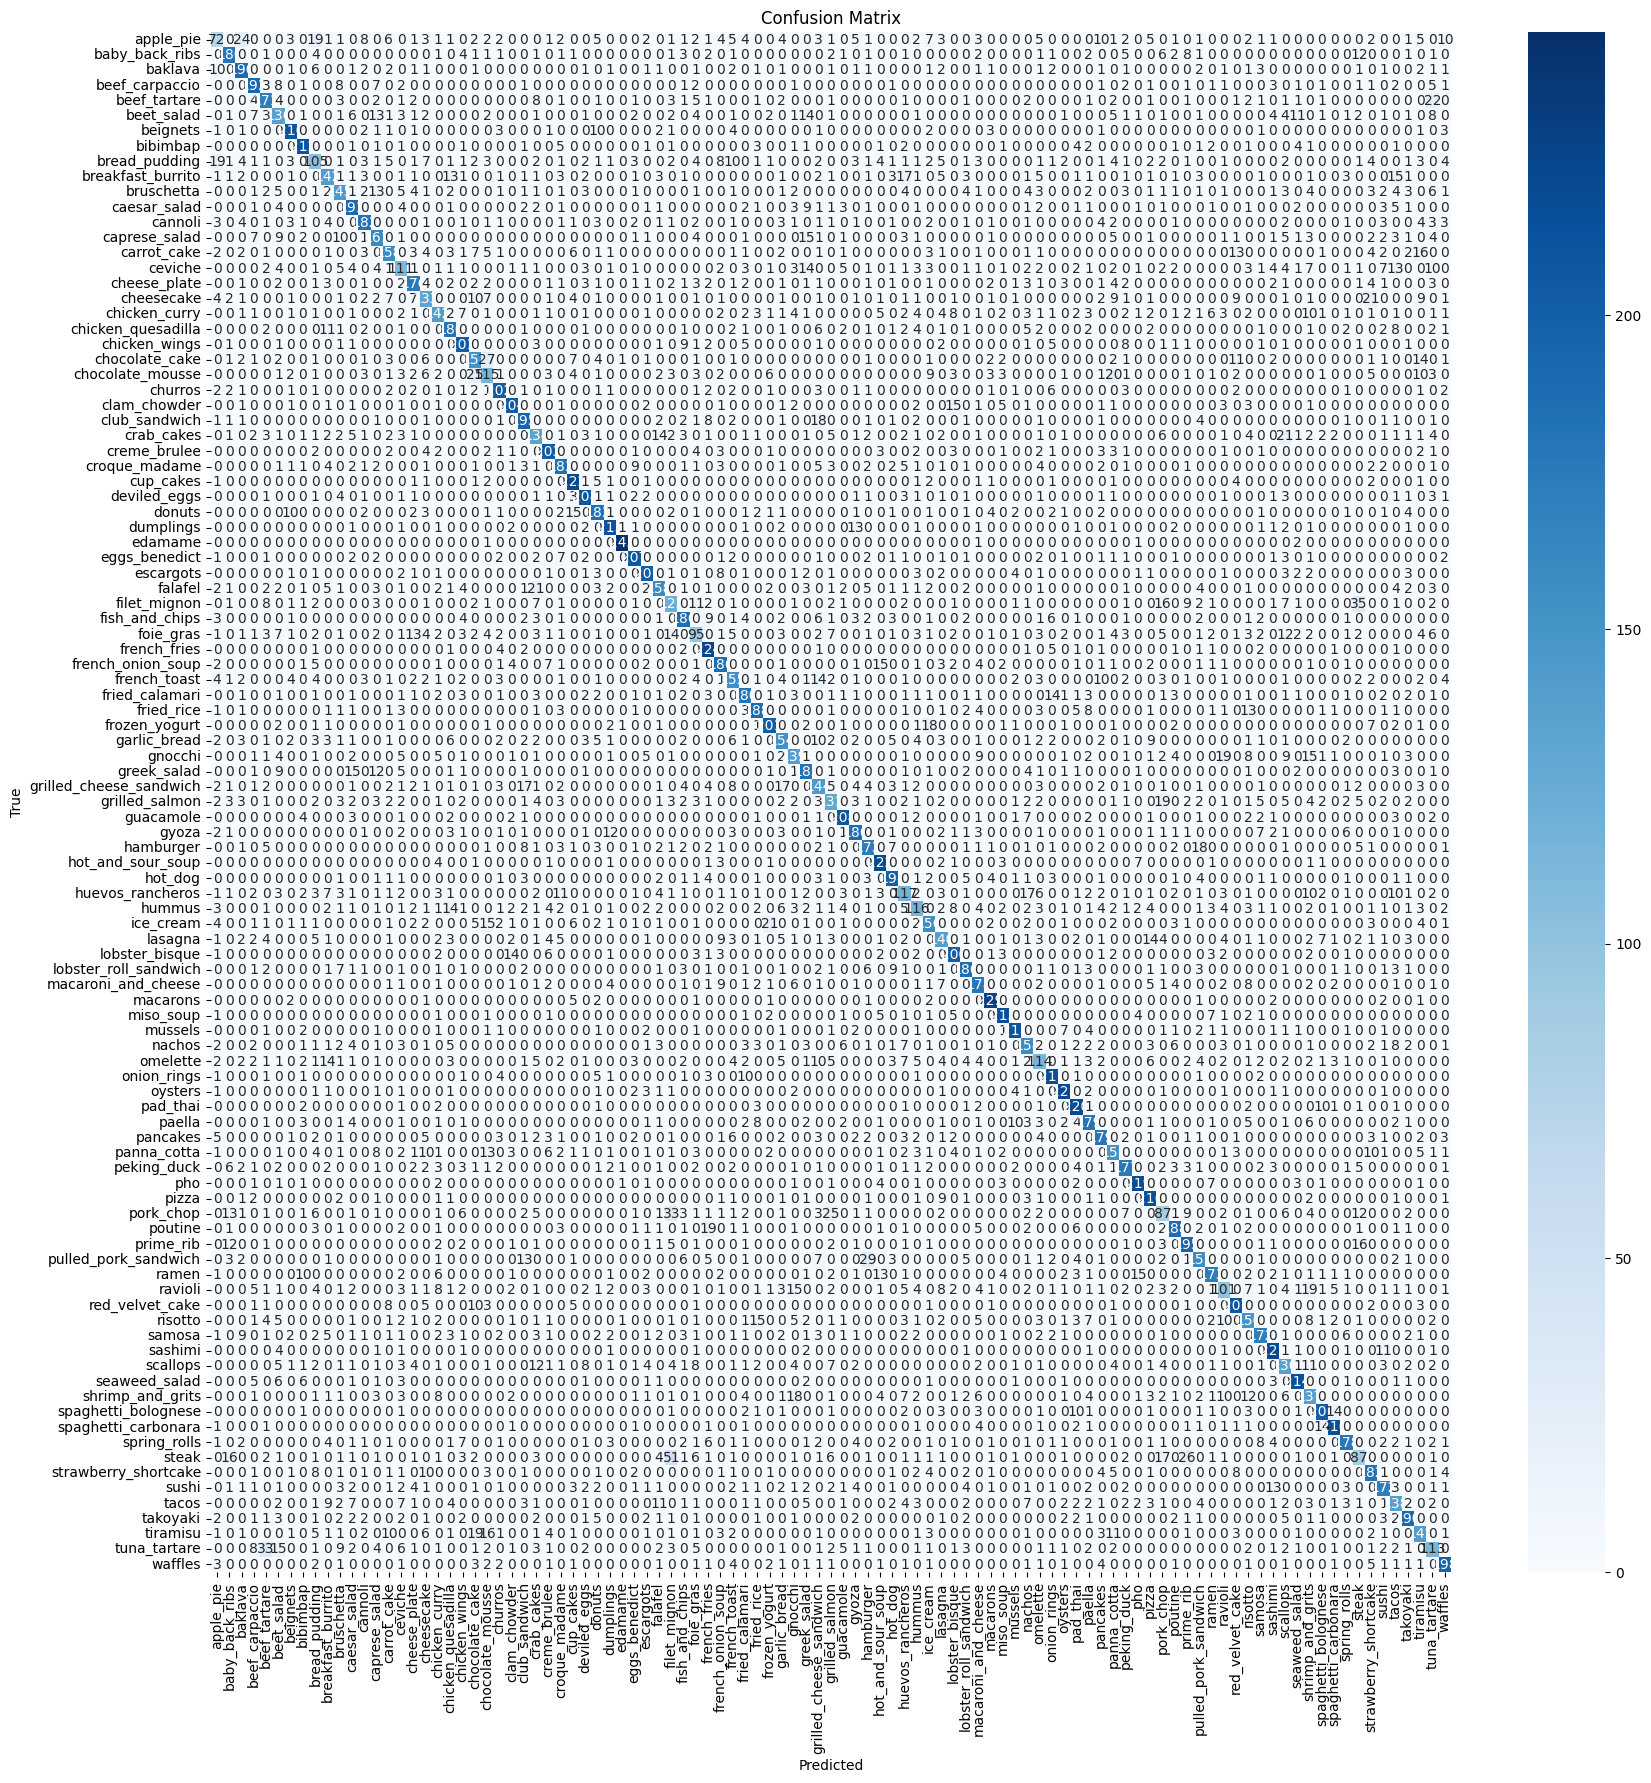

In [ ]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_images.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_images.class_indices.keys()),
            yticklabels=list(test_images.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Thats the End of my Work. Why not you Bulid on this file and retrain the model check point with fully Layers Trainable. And check how it effects the results.
Thank you